# Step 1: Descriptive Analysis 
This notebook belongs to the first step of the analysis. First, necessary packages and files are imported, variables are defined and functions are created. Then, the descriptive analysis is done. 

## 0. Preparation 

### 0.1 Import packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from adjustText import adjust_text
import os
import warnings

In [2]:
#Removing warnings
warnings.filterwarnings('ignore') 

### 0.2 Import files

In [3]:
#Reading the merged_names file
survey_data = pd.read_csv('../datafiles/transformed_names.csv')
#Reading the shapefile
gdf = gpd.read_file("../shapefiles/UK_plot/infuse_msoa_lyr_2011.shp")

In [4]:
#Now reading the csv files with the MSOA names belonging to the base regions
ns_region = pd.read_csv('../datafiles/norfolk_suffolk_region.csv')
#Somerset
somerset_region= pd.read_csv('../datafiles/somerset_region.csv')
#London
london_region=pd.read_csv('../datafiles/london_region.csv')
#The London boroughs, for better visualisation 
london_borough=gpd.read_file('../shapefiles/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

In [5]:
#Now reading the csv files of the survey data split by MSOA regions
filtered_ns = pd.read_csv('../datafiles/filtered_ns.csv')
#Somerset
filtered_somerset= pd.read_csv('../datafiles/filtered_somerset.csv')
#London
filtered_london=pd.read_csv('../datafiles/filtered_london.csv')

### 0.3 Predefining variables and colour lists
In this section, colours for plots are defined and variables are predefined for further analysis.

In [6]:
#Defining the valid values as a response for the trust variable question
valid_values=[1, 2, 3, 4, 5, 97, 98, 99]

In [7]:
#Colours are matched with values in a dictionary for the stacked bar plot
stack_colours = {
    1: '#4e6d91',
    2: '#90ac8c',
    3: '#f4c539',
    4: '#e78942',
    5: '#d7384e',
    97: 'beige',
    98: 'lightgrey',
    99: 'grey'
}

In [8]:
#These are the colours for the msoa counts map I want to use, each belonging to a category. Again, a dictionary is created with keys. 
map_colours ={ 
    '1–5': '#4e6d91', 
    '6–10': '#90ac8c', 
    '11–15': '#f4c539', 
    '16–20': '#e78942', 
    '21-25': '#d7384e'
}

In [9]:
#Defining the labels in a list for mapping colours onto these labels 
labels=['1–5', '6–10', '11–15', 
        '16–20', '21-25']

In [10]:
#Creating colors from a list by mapping the values from the labels list onto the dictionary
custom_col_map = ListedColormap([map_colours[label] for label in labels])

In [11]:
# Convert the stack_colors dictionary to a list of colors for implementing in the bar plot
colour_list = [colour for key, colour in sorted(stack_colours.items())]

In [12]:
# Create a custom colormap from the color list for my stacked bar plot
custom_cmap = LinearSegmentedColormap.from_list("custom_colors", colour_list)

### 0.4 Labels
Here I define the labels I want to use for my plots. 

In [13]:
#Dictionary to define my labels for the stacked bar plot
label_trust ={
    1:'1- No trust',
    2:'2',
    3:'3',
    4:'4',
    5: '5- Full trust',
    97: 'Other',
    98: "Don't know", 
    99: 'PNTS'
}


### 0.5 Renaming and selecting columns
In this section,  I rename variables for better interpretation. Moreover, if necessary I select columns that are needed for the analysis.

In [14]:
#Renaming columns for merging later on
gdf=gdf.rename(columns={'geo_label': 'MSOA name'})
london_borough=london_borough.rename(columns={'NAME': 'LA name'})

In [15]:
#Renaming the columns of my dataframes for better visibility and setting type MSOA to string for better merge
for i in [gdf, filtered_ns, filtered_somerset, filtered_london]: 
    i['MSOA name'] = i['MSOA name'].astype('str')
    i=i.rename(columns={'Trust Prime Minister': 'Prime Minister', 
                  'Trust Government Representative': 'Government Representative', 
                 'Trust Family and Friends': 'Family and Friends', 
                  'Trust General Media': 'General Media', 
                 'Trust Social Media': 'Social Media'}, inplace=True)

In [16]:
#Choosing only geometry in gdf 
gdf=gdf[['MSOA name', 'geometry']]

### 0.6 Functions

In this section, I define functions used in the rest of the notebook.

In [17]:
def set_bounds_gdf(gdf):
    # This function sets the bounds for my maps. It takes the total bounds of the input dataframe 
    #This takes the min and max coordinates of the geometries in the dataframe
    minx, miny, maxx, maxy = gdf.total_bounds
    #Calculates the ratio by calculating height and width
    aspect = (maxy - miny) / (maxx - minx)
    #Sets the wanted width to 8
    width = 8
    #Calculates the corresponding height according to the ratio
    height = width * aspect
    #Returns the width and height for further analysis
    return width, height

In [18]:
def set_bins(df):
    # This function calculates new bins for the msoa counts. It has 5 categories, and it creates
    # a new column in the input dataframe with the corresponding category. 
    df['count_bin'] = pd.cut(
        df['count'],          
        bins=[0, 5, 10, 15, 20, 25],
        labels=labels,
        include_lowest=True
    )
    # Sets the count_bin column to categorical to avoid issues while plotting
    df['count_bin'] = pd.Categorical(df['count_bin'], categories=labels, ordered=True)
    return df

In [19]:
def plot_msoa_counts(gdf,counts,name_plot, folder="../figures"):
    # This function plots the counts of respondents from a specific MSOA region 
    # In the survey data
    
    #Calculate the bounds with the function seen above
    x, y = set_bounds_gdf(gdf)
    #Calculate the bins
    new_bins=set_bins(counts)
    # Plotting the base of the region 
    fig, ax = plt.subplots(figsize=(x, y))
    gdf.plot(ax=ax, color='#f0f0f0', edgecolor='black', linewidth=0.2)

    #Plotting the counts per MSOA region over the base region
    new_bins.plot(ax=ax, cmap=custom_col_map, column='count_bin', categorical=True, legend=True, edgecolor='black', linewidth=0.2, alpha=1, legend_kwds={'title': 'Categories respondent counts'})

    #This is to add the MSOA region names to the plots. It locates the centre of the MSOA region and labels 
    #the region according to either the MSOA or LA name (for London)
    texts = []
    for idx, row in counts.iterrows():
        x, y = row['geometry'].centroid.coords[0]
        label = row['MSOA name'] if gdf.equals(gdf_ns) or gdf.equals(gdf_somerset) else row['LA name']
    
        # Adds text object to the plot with size and colour. 
        text = ax.text(x, y, label, fontsize=7, weight='bold', ha='right', color='black')
        texts.append(text)
    
    # This adjusts the text positions and draw arrows from the text to the region
    adjust_text(texts,arrowprops=dict(arrowstyle='-', color='black', lw=0.7, linestyle='--'))

    #Remove axes and add title
    ax.set_axis_off()
    ax.set_title(name_plot)

    #Constructs a path for saving the figure
    full_path = os.path.join(folder, name_plot)
    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [20]:
def show_rows(df):
    #This is a function that shows the number of rows in a dataframe. 
    row_count = df.shape[0]
    return  f"The number of rows in this dataframe is {row_count}"

In [21]:
def percentage_calc(df):
    #This calculates the relative frequency distribution by normalising the value counts
    # of each category and multiplying it by 100 to get the percentage
    return df.apply(lambda col: col.value_counts(normalize=True).round(3) * 100)

In [22]:
def stats_function(df):
    # This function calculates the basic statistics for each region and category, without taking 
    # values 97, 98 and 99 into account 
    stats = pd.DataFrame({
        'Median': df[~df.isin([97,98, 99])].median(),
        'Mode': df[~df.isin([97, 98, 99])].mode(dropna=True).iloc[0],
        'Mean': df[~df.isin([97, 98, 99])].mean().round(2),
        'STD': df[~df.isin([97, 98, 99])].std().round(2)
    })

    # This adds the relative frequency distribution for the categories
    freqs = percentage_calc(df)

    for var in valid_values:
        #I only want the frequency in my table if the value is one to five
        if var in freqs.index:
            if var in [1,2,3,4,5]:
                stats[f'% - {var}'] = freqs.loc[var].values
            else:
                pass
        
    # # I want to rename the dataframe according to the dictionary rename_columns        
    # stats_renamed = stats.rename(index=rename_columns)

    #Return dataframe for further use
    return stats

In [23]:
def comparison_stacked(columns_list, folder="../figures/step1"): 
    # This function plots the stacked bar plot. 

    #Creating a list of dataframes that need to be combined
    all_combined_df=[]

    
    region_labels = ['Norfolk/Suffolk', 'Somerset', 'Greater London']

    #This is the order of categories I want in my stacked bar plot
    category_order = [1,2,3,4,5,97,98,99]

    #Creating a dictionary by pairing the order to a colour
    category_col = dict(zip(category_order, colour_list))

    #Creating a new list as I do not want to change my original input list
    clean_columns=columns_list

    #Calculate the relative frequency distribution for each trust variable in each area dataframe
    for col in clean_columns:
        
        pct_area1 = percentage_calc(filtered_ns[[col]])[col]
        pct_area2 = percentage_calc(filtered_somerset[[col]])[col]
        pct_area3 = percentage_calc(filtered_london[[col]])[col]

        #Combining the percentages for each trust variable and each category and creating rows
        combined = pd.DataFrame({
            'Norfolk/Suffolk': pct_area1,
            'Somerset': pct_area2,
            'Greater London': pct_area3,
        })

        #Reindex according to the category order and filling nan values 
        combined = combined.reindex(category_order).fillna(0)

        #Adding an extra column to identify the trust variable
        combined['Variable'] = col

        #Appending the created dataframe into the list
        all_combined_df.append(combined)


    # Concatenate all dataframes of each trust variable
    plot_bar_trust = pd.concat(all_combined_df)
    plot_bar_trust = plot_bar_trust.reset_index().rename(columns={'index': 'Category'})
    

    # Pivot to a long-form dataFrame for plotting, keeping variable and category as identifiers
    pivot_trust = pd.melt(plot_bar_trust, id_vars=['Variable', 'Category'], 
                        value_vars=region_labels, var_name='Region', value_name='Percent')

    # Plotting the bar plot
    fig, ax = plt.subplots(figsize=(18, 7))

    #Setting the categories for the plot
    categories = pivot_trust['Category'].unique()
    #Setting bar width
    bar_width = 0.75
    #Setting the number of variables to the number of trust columns
    num_vars = len(clean_columns)
    
    # Creating empty lists for the bar positions and labels 
    bar_positions = []
    bar_labels = []

    #Iterating through the trust columns
    for i, var in enumerate(clean_columns):
        #Setting the start of the trust variable in a grouped bar chart
        group_start = i * num_vars
        #Looping through the regions
        for j, region in enumerate(region_labels):
            #Calculates the x position of each individual bar
            pos= group_start + j
            #Appending the positions in the lists
            bar_positions.append(pos)
            bar_labels.append(region)
    
    # This is to draw the actual bars
    index = 0
    #Iterating through the trust variables again
    for i, var in enumerate(clean_columns):
        #Setting the variable for each group of bars
        region_data = pivot_trust[pivot_trust['Variable'] == var]
        #Iterating through the regions again
        for j, region in enumerate(region_labels):
            #Setting the region for each bar
            sub_data = region_data[region_data['Region'] == region]
            bottom = 0
            #Setting the categories within each bar to stack them
            for cat in category_order:
                #Takes the values per category
                val = sub_data[sub_data['Category'] == cat]['Percent'].values
                #Checks if there is a value for the category. If not then 0 for the stack to build
                height = val[0] if val.size else 0
                #Settings for the bars
                ax.bar(
                    bar_positions[index],
                    height,
                    bar_width,
                    bottom=bottom,
                    color=category_col[cat],  
                    label=label_trust[cat] if index == 0 else None)
                #Each iteration you increase the bottom by cumulative height
                bottom += height
            #Moves to the next x position/bar after working on the current one
            index += 1
    
    # Set region names below each bar and ticks below each bar
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(bar_labels, fontsize=16, rotation=45, ha='right')
    ax.set_ylabel("Percent", fontsize=16, rotation=45, labelpad=16)
    ax.tick_params(axis='y', labelsize=16)
    
    # Identifies centers of column names below each group using axis coordinates
    group_centers = [np.mean(bar_positions[i * len(region_labels):(i + 1) * len(region_labels)]) for i in range(len(clean_columns))]
    
    # Converting group centers from data to axis coordinates
    for center, var in zip(group_centers,clean_columns):
        x_axis_coord = (center - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
        ax.text(x_axis_coord, -0.4, var, ha='center', va='top', transform=ax.transAxes, fontsize=16)
        
    # Now last adjustments to the plot
    title="Relative frequency distribution of trust variables"
    ax.set_title(title, fontsize=20, loc='center')
    ax.legend(title="Category", bbox_to_anchor=(0.85, -0.5), title_fontsize=18, fontsize=16,loc='upper left')
    #Necessary to adjust correct spacing
    plt.subplots_adjust(bottom=0.25)

    #Creating the path and saving the figure
    full_path = os.path.join(folder, title)
    plt.savefig(full_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
    plt.show()
      

## 1. First insight
First, an initial insight is given into the dataframes. Then, MSOA counts per region are shown. This is not necessarily used in Step1 but is added in the appendix of the thesis for further analysis of the results. 

### 1.1 Initial insight

In [24]:
#How many respondents there are from NS
show_rows(filtered_ns)

'The number of rows in this dataframe is 256'

In [25]:
#How many respondents there are from Somerset
show_rows(filtered_somerset)

'The number of rows in this dataframe is 129'

In [26]:
#How many respondents there are from Somerset
show_rows(filtered_london)

'The number of rows in this dataframe is 358'

### 1.2 Plotting MSOA counts per region


### Norfolk/Suffolk Region

In [27]:
#Counting how respondents there are per MSOA region
msoa_counts_ns=filtered_ns['MSOA name'].value_counts()

I also want to create a plot with the respondent count per MSOA region. For that I need to merge the geodataframe and the survey data frame for the area norfolk/suffolk. 

In [28]:
#Only selecting the regions of Norfolk/Suffolk
gdf_ns=gdf[gdf['MSOA name'].isin(ns_region['MSOA name'])]

In [29]:
#Merging the spatial dataframe and the MSOA counts
merged_ns_counts=gdf_ns.merge(msoa_counts_ns, on='MSOA name', how='right')

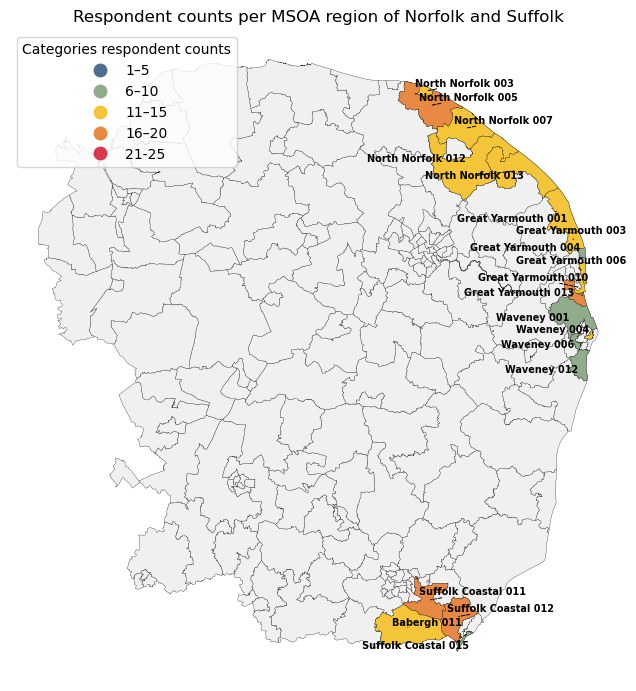

In [30]:
#Using the function above to create the bins and to plot the number of msoa's per region
plot_msoa_counts(gdf_ns,merged_ns_counts,"Respondent counts per MSOA region of Norfolk and Suffolk")

### Somerset Region
Same is done for the Somerset regions.

In [31]:
#Counting how respondents there are per MSOA region
msoa_counts_somerset=filtered_somerset['MSOA name'].value_counts()

In [32]:
#Only selecting the regions of Somerset
gdf_somerset=gdf[gdf['MSOA name'].isin(somerset_region['MSOA name'])]

In [33]:
#Merging the spatial dataframe and the MSOA counts
merged_somerset_counts=gdf_somerset.merge(msoa_counts_somerset, on='MSOA name', how='right')

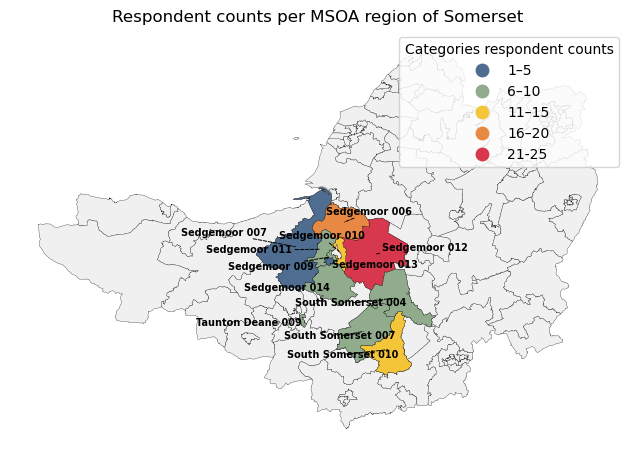

In [34]:
#Using the function above to create the bins and to plot the number of msoa's per region
plot_msoa_counts(gdf_somerset,merged_somerset_counts,"Respondent counts per MSOA region of Somerset")

### Greater London

In [35]:
#Only selecting the necessary columns out of london borough and london region
london_borough=london_borough[['LA name', 'geometry']]
london_region=london_region[['MSOA name', 'LA name']]

In [36]:
# Merging Local Authorities with MSOA's for better plotting
filtered_london_la = london_region.merge(filtered_london, on = 'MSOA name', how='right')

In [37]:
#Value counting number of respondents per region
la_counts_london=filtered_london_la['LA name'].value_counts()

In [38]:
#Merge the LA names to the geodataframe of London boroughs
london_plot_gdf=london_borough.merge(la_counts_london, on = 'LA name', how='right')

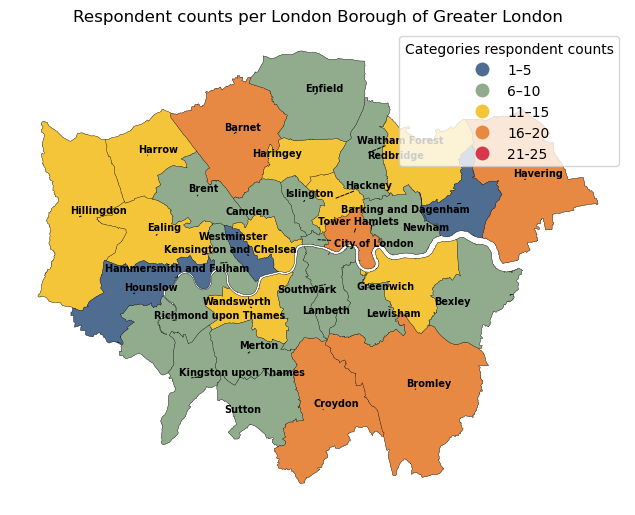

In [39]:
#Using the function above to create the bins and to plot the number of msoa's per region
plot_msoa_counts(london_borough,london_plot_gdf,"Respondent counts per London Borough of Greater London")

## 2. Trust analysis for the regions

In this section, the trust levels per region are assessed by using descriptives. Then, the trust levels are compared between the different regions by using a stacked bar plot.

In [40]:
#These are the trust variables to be analysed
selected_columns=['Prime Minister','Government Representative','Family and Friends','General Media','Social Media']                           

### 2.1 Norfolk/Suffolk

In [41]:
#Selecting only trust variables
filtered_ns_trust=filtered_ns[selected_columns]

In [42]:
#Performing the stats function
ns_stats=stats_function(filtered_ns_trust)

### 2.2 Somerset

In [43]:
#Selecting only trust variables
filtered_somerset_trust = filtered_somerset[selected_columns]

In [44]:
#Performing the stats function
somerset_stats=stats_function(filtered_somerset_trust)

### 2.3 Greater London

In [45]:
#Selecting only trust variables
filtered_london_trust = filtered_london[selected_columns]

In [46]:
#Performing the stats function
london_stats=stats_function(filtered_london_trust)

### 2.4 Concatenating the three dataframes
Now I want to concatenate the three dataframes created by the stats function. 

In [47]:
#Adding region columns to the dataframes
ns_stats['Region']='Norfolk/Suffolk'
somerset_stats['Region']='Somerset'
london_stats['Region']='Greater London'

In [48]:
#Resetting the index for all dataframes
ns_stacked = ns_stats.stack(dropna=False).reset_index()
somerset_stacked = somerset_stats.stack(dropna=False).reset_index()
london_stacked  = london_stats.stack(dropna=False).reset_index()

In [49]:
#Selecting the columns for all dataframes
ns_stacked.columns = ['Variable', 'Statistic', 'Norfolk/Suffolk']
somerset_stacked.columns = ['Variable', 'Statistic', 'Somerset']
london_stacked.columns  = ['Variable', 'Statistic', 'Greater London']

In [50]:
#Merging all dataframes
merged_stats = ns_stacked.merge(somerset_stacked, on=['Variable', 'Statistic']) \
                            .merge(london_stacked, on=['Variable', 'Statistic'])

In [51]:
#Removing rows that contain Region, and not a specific region name
merged_stats_clean=merged_stats[merged_stats['Statistic'] != 'Region']

In [52]:
#Print in Latex style for overleaf tabel
print(merged_stats_clean.to_latex(index=False, float_format=lambda x: f"{x:.2f}".rstrip('0').rstrip('.')))

\begin{tabular}{lllll}
\toprule
Variable & Statistic & Norfolk/Suffolk & Somerset & Greater London \\
\midrule
Prime Minister & Median & 1 & 2 & 2 \\
Prime Minister & Mode & 1 & 1 & 1 \\
Prime Minister & Mean & 1.93 & 2.13 & 2.29 \\
Prime Minister & STD & 1.13 & 1.24 & 1.26 \\
Prime Minister & % - 1 & 48 & 43.4 & 36.3 \\
Prime Minister & % - 2 & 12.1 & 14.7 & 17 \\
Prime Minister & % - 3 & 23 & 20.9 & 21.5 \\
Prime Minister & % - 4 & 5.9 & 11.6 & 13.1 \\
Prime Minister & % - 5 & 2.3 & 3.9 & 5 \\
Government Representative & Median & 3 & 3 & 3 \\
Government Representative & Mode & 3 & 4 & 3 \\
Government Representative & Mean & 2.6 & 2.94 & 2.98 \\
Government Representative & STD & 1.2 & 1.29 & 1.21 \\
Government Representative & % - 1 & 25.4 & 20.9 & 15.1 \\
Government Representative & % - 2 & 14.8 & 12.4 & 13.7 \\
Government Representative & % - 3 & 30.5 & 23.3 & 29.9 \\
Government Representative & % - 4 & 20.3 & 33.3 & 24.9 \\
Government Representative & % - 5 & 3.5 & 7.8 & 8.7 \\
Fam

## 3. Comparing trust between the Areas
In this section, the stacked bar plot is generated by using the bar charts function.

## 3.1 Bar charts

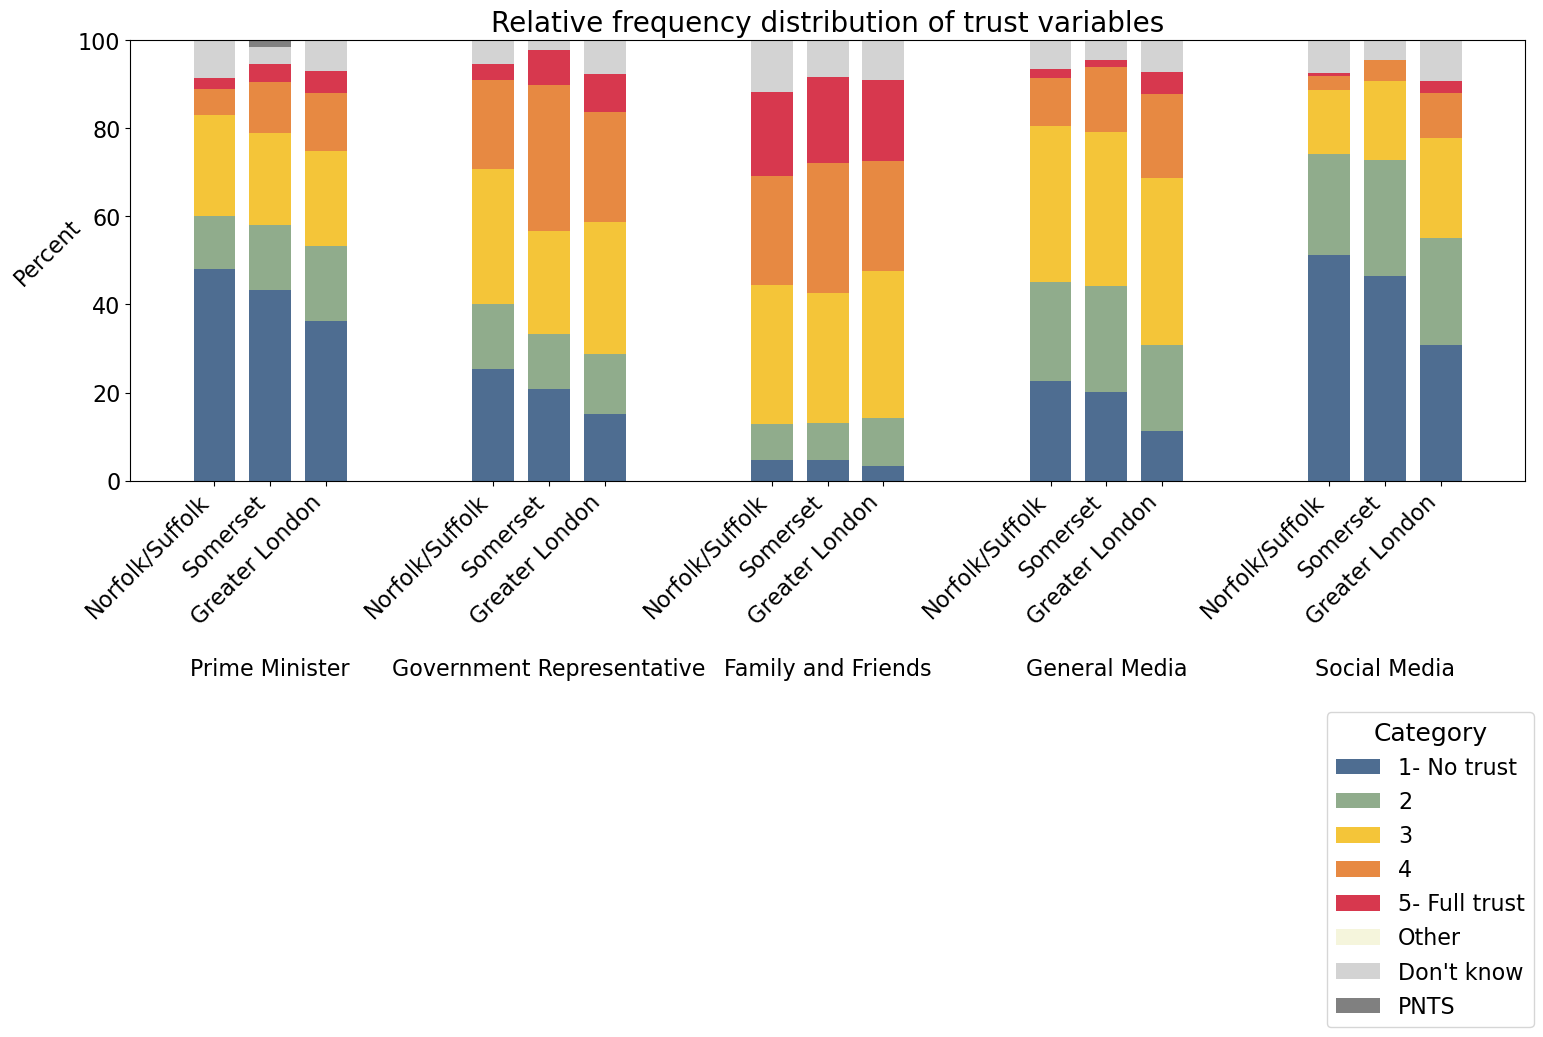

In [53]:
comparison_stacked(selected_columns)